<a href="https://colab.research.google.com/github/cmannnn/practical_deep_learning_for_coders/blob/main/ch_4_digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MNIST digit recognizer

In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 4.2 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 186 kB 51.3 MB/s 
     |████████████████████████████████| 1.2 MB 37.2 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
     |████████████████████████████████| 51 kB 297 kB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

##Q1

Create your own implementation of Learner from scratch, based on the training loop shown in this chapter.

In [ ]:
# setting the path to the MNIST dataset
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [ ]:
# grabbing just the threes and sevens form the training set to use
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [ ]:
# opening the training 3's/7's and changing them to tensors
three_tensor = [tensor(Image.open(o)) for o in threes]
seven_tensor = [tensor(Image.open(o)) for o in sevens]

In [ ]:
# creating Pytorch tensors of the valid 3s and 7s
valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])

valid_7_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'7').ls()])

In [ ]:
# stacking three_tensor  normalize the train 3 tensor
stacked_threes = torch.stack(three_tensor).float()/255

# stack then normalize the train 7 tensor
stacked_sevens = torch.stack(seven_tensor).float()/255

# normalizing the valid 3 tensor (valid_3_tens already stacked)
valid_3_tens = valid_3_tens.float()/255

# normalizing the valid 7 tensor (valid_3_tens already stacked)
valid_7_tens = valid_7_tens.float()/255

In [ ]:
# changing the training rank 3 tensors to a rank 2 tensor using view
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

# changing the testing rank 3 tensors to a rank 2 tensor using view
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)

In [ ]:
# creating labels for our training data as a column vector
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

# creating labels for our testing data as a column vector
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)

In [ ]:
# zipping the x, y training dataset
dset = list(zip(train_x, train_y))
dl = DataLoader(dset, batch_size = 256)

# zipping the x, y training dataset
valid_dset = list(zip(valid_x, valid_y))
valid_dl = DataLoader(valid_dset, batch_size = 256)

# loading training DataLoader and testing DataLoader
ds = DataLoaders(dl, valid_dl)

In [ ]:
# creating the neural net
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1),
    nn.Sigmoid()
)

In [ ]:
# PyTorch binary optimization function? nn.BCELoss

In [ ]:
# creating new class Learner that takes dataloaders object, the model, optimizer function, and the loss function
class Learner():

 # initializing 
  def __init__(self,dataloaders,model,opt,loss):
    self.training_dl = dataloaders[0]
    self.valid_dl = dataloaders[1]
    self.model = model
    self.opt = opt(self.model.parameters(), lr = 0.01)
    self.loss_func = loss

# defining batch accuracy that takes the predictions and the y labels 
  def batch_accuracy(self, preds, yb):
    correct = (preds > 0.5) == yb
    return correct.float().mean()

# defining validate epoch that measures accuracy for each training set batch and rounds to 4 digits
  def validate_epoch(self):
    accs = [self.batch_accuracy(self.model(xb), yb) for xb, yb in self.valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

# defining train epoch that takes xb, yb from training set, define the loss func and calculate backpropagation
  def train_epoch(self):
    for xb, yb in self.training_dl:
      preds = self.model(xb)
      calculated_loss = self.loss_func(preds, yb * 1.0)
      calculated_loss.backward()
      self.opt.step()
      self.opt.zero_grad()
 
# fits the model for n numbers of epochs and prints them to the screen
  def fit(self, n):
    for epoch in range(n):
      self.train_epoch()
      print(self.validate_epoch(), end=' ')

In [ ]:
# testing the Learner class inserting the combined dataloaders set, the simple_net created, SGD as the optimizer
# and the PyTorch binary loss function 
test = Learner(ds, simple_net, SGD, nn.BCELoss())
test.fit(30)

0.9145 0.9409 0.955 0.9609 0.9648 0.9643 0.9662 0.9677 0.9677 0.9687 0.9687 0.9691 0.9696 0.9701 0.9711 0.9716 0.9716 0.9711 0.9716 0.9725 0.9735 0.9735 0.9735 0.9735 0.9735 0.974 0.974 0.974 0.974 0.974 

##Q2

Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! 

In [4]:
# setting the path
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

In [5]:
# checking path
path.ls()

(#2) [Path('training'),Path('testing')]

In [6]:
# creating a image datablock
mnist = DataBlock(blocks = (ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
                  get_y=parent_label)

In [7]:
# loading data into dls
dls = mnist.dataloaders(path, num_workers = 0)

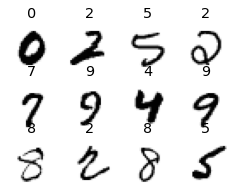

In [8]:
# printing a couple of numbers
dls.show_batch(max_n = 12, figsize = (4,3))

In [13]:
# creating the second simple_net
simple_net = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
)

In [ ]:
# creating second learner
class Learner():
  
  def __init__(self,dataloaders, model, opt, loss):
    self.train_dl = dataloaders[0]
    self.test_dl = dataloaders[1]
    self.model = model
    self.opt = opt(self.model.parameters(), lr = 0.01)
    self.loss = loss

  def train_epoch(self):
    for xb,yb in self.train_dl:
      preds = self.model(xb)
      calculated_loss = self.loss(preds, yb.long())
      calculated_loss.backwards()
      self.opt.step()
      self.opt.zero_grad()